**Before using this Colab, please save a copy to your own Google Drive:
Click on “File” > “Save a copy in Drive”**

# **AI Assisted Literature Review Part II RAG/LLM**
# *A. Download Research Papers of interest*
# *B. Demo:Pre-process the downloaded file*   
# *C. Demo:Query your newly created RAG/LLM*


# This Colab notebook processes scientific papers, extracts metadata, creates a searchable vector database, and enables interactive question-answering using the Retrieval-Augmented Generation (RAG) approach with Groq's LLM. You can easily query the system for answers based on the processed documents.

### **WORKFLOW:**
* Install necessary libraries.
* Set Groq API Key
* Download research paper using [pygetpapers](https://github.com/petermr/pygetpapers)
* Parse XML/PDF Files to Markdown and Extract Metadata
* Create Vector Database
* Execute pipeline for Processing and Retrieval
* Query your newly created RAG/LLM

### **Step 1: Install dependencies**
* **pymupdf4llm:** Lightweight PDF processing for LLMs
* **langchain:** Framework for developing LLM-powered applications
* **chromadb:** Vector store for storing and querying embeddings
* **sentence-transformers:** For embedding sentences using transformer models



In [ ]:
# Install dependencies
!pip install pygetpapers
!pip install lxml
!pip install langchain chromadb sentence-transformers
!pip install -U langchain-huggingface
!pip install -U langchain-community langchain-groq
!pip install pymupdf markdown2 weasyprint

### **Step 2: Set Groq API Key**
Groq’s LPU (Language Processing Unit) hardware enables real-time, low-latency responses from LLMs—ideal for interactive applications.

**Instructions:**
* Go to https://console.groq.com/

* Create an account if you don’t have one

* Generate your API token

* Copy and paste it when prompted below
* CLICK **ENTER** once done.

In [ ]:
#  Set API Key
import os, getpass
os.environ["GROQ_API_KEY"] = getpass.getpass("🔐 Enter your Groq API Key: ")

🔐 Enter your Groq API Key: ··········


### **Step 3: Download Research Papers**
Use *pygetpapers* to fetch research articles related to the keyword.

In [ ]:
# Download papers from EuropePMC
!pygetpapers --query '"phytochemicals"' --xml --limit 10 --output /content/phytochemical_data --save_query

INFO: Total Hits are 77821
10it [00:00, 73713.60it/s]
INFO: Saving XML files to /content/phytochemical_data/*/fulltext.xml
100% 10/10 [00:13<00:00,  1.40s/it]


### **Step 4: Parse XML/PDF Files to Markdown and Extract Metadata**
Convert scientific articles (downloaded in XML format) into clean Markdown format and extract essential metadata like title, authors, and DOI.

In [ ]:
#  Parse XMLs to Markdown and extract metadata
import pathlib
import re
from lxml import etree
import fitz  # PyMuPDF
from datetime import datetime

def sanitize_filename(name):
    return re.sub(r'[\/:"*?<>|]+', "_", name)

def extract_text_from_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        return text.strip()
    except Exception as e:
        print(f"❌ Error extracting PDF {pdf_path.name}: {e}")
        return ""

def parse_xml_to_markdown_with_metadata(xml_path):
    try:
        with open(xml_path, 'rb') as f:
            tree = etree.parse(f)

        metadata = {
            "title": "",
            "authors": [],
            "doi": "",
        }

        title_elem = tree.find(".//article-title")
        if title_elem is not None:
            full_title = title_elem.xpath("string()").strip()
            metadata["title"] = full_title if full_title else xml_path.stem
        else:
            metadata["title"] = xml_path.stem

        doi_elem = tree.find(".//article-id[@pub-id-type='doi']")
        if doi_elem is not None and doi_elem.text:
            metadata["doi"] = "https://doi.org/" + doi_elem.text.strip()

        authors = []
        for contrib in tree.findall(".//contrib[@contrib-type='author']"):
            name = contrib.find('name')
            if name is not None:
                given = name.findtext('given-names', default='')
                surname = name.findtext('surname', default='')
                full_name = f"{given} {surname}".strip()
                if full_name:
                    authors.append(full_name)

        metadata["authors"] = ", ".join(authors)

        sections = tree.xpath('//body//sec')
        text_parts = []

        for sec in sections:
            title = sec.findtext('title')
            if title:
                text_parts.append(f"### {title.strip()}")
            paragraphs = sec.findall('p')
            for p in paragraphs:
                if p.text and p.text.strip():
                    text_parts.append(p.text.strip())

        markdown_text = "\n\n".join(text_parts)
        return markdown_text, metadata

    except Exception as e:
        print(f"❌ Error parsing {xml_path.name}: {e}")
        return None

def process_input_path(input_path, output_dir):
    input_path = pathlib.Path(input_path)
    output_path = pathlib.Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    metadata_records = []

    if input_path.is_file():
        if input_path.suffix.lower() == ".xml":
            result = parse_xml_to_markdown_with_metadata(input_path)
            if result:
                raw_text, metadata = result
                if raw_text.strip():
                    final_name = sanitize_filename(input_path.stem) + "_final.md"
                    final_path = output_path / final_name
                    final_path.write_text(raw_text, encoding="utf-8")
                    metadata["filename"] = final_path.name
                    metadata_records.append((final_path, metadata))

        elif input_path.suffix.lower() == ".pdf":
            text = extract_text_from_pdf(input_path)
            if text:
                # Extract better title from first few lines
                first_lines = text.split('\n')[:3]
                title_candidate = next((line.strip() for line in first_lines if len(line.strip()) > 10), input_path.stem)
                title_candidate = title_candidate.replace("_", " ").strip().title()

                # Try to extract DOI using regex
                doi_match = re.search(r"(10\.\d{4,9}/[-._;()/:A-Z0-9]+)", text, re.I)
                doi = f"https://doi.org/{doi_match.group(1)}" if doi_match else ""

                final_name = sanitize_filename(input_path.stem) + "_final.md"
                final_path = output_path / final_name
                final_path.write_text(text, encoding="utf-8")

                metadata = {
                    "title": title_candidate,
                    "authors": "Unknown",
                    "doi": doi,
                    "filename": final_path.name
                }

                metadata_records.append((final_path, metadata))

    elif input_path.is_dir():
        for file in input_path.glob("**/*"):
            metadata_records += process_input_path(file, output_dir)

    return metadata_records

### **Step 5:Create Vector Database**
Process documents to store them as vectors, enabling question-answering with a retrieval system.

In [ ]:
#  Load and Chunk Documents with Metadata
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings as HFEmbeddings


def load_markdown_documents_with_metadata(metadata_records):
    documents = []
    for md_path, metadata in metadata_records:
        text = md_path.read_text(encoding="utf-8")
        if text.strip():
            doc = Document(page_content=text, metadata=metadata)
            documents.append(doc)
    return documents

def hybrid_chunking(documents, threshold=3000):
    chunks = []
    for doc in documents:
        if len(doc.page_content.strip()) <= threshold:
            chunks.append(doc)
        else:
            splitter = RecursiveCharacterTextSplitter(chunk_size=1800, chunk_overlap=300)
            split_docs = splitter.split_documents([doc])
            for chunk in split_docs:
                chunk.metadata.update(doc.metadata)
            chunks.extend(split_docs)
    return chunks

def create_vector_database(chunks):
    embeddings = HFEmbeddings(model_name="all-mpnet-base-v2")
    vector_db = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        collection_name="scientific_rag_db",
        persist_directory="/content/db"
    )
    return vector_db

def create_retrieval_chain(vector_db):
    llm = ChatGroq(
        model="llama3-70b-8192",
        temperature=0.2,
        max_tokens=512,
        api_key=os.environ.get("GROQ_API_KEY")
    )
    prompt_template = PromptTemplate.from_template(
        '''You are an expert scientific research assistant with access to reliable academic content. Based on the context provided, answer the user’s question as accurately and concisely as possible. When appropriate, include definitions, examples, or explanations to enhance clarity. If the context does not contain enough information to answer the question, say so honestly.

Context:
{context}

Question: {question}

Answer:'''
    )
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vector_db.as_retriever(search_kwargs={"k": 3}),
        return_source_documents=True,
        chain_type_kwargs={"prompt": prompt_template}
    )
    return qa_chain

### **Step 6: Execute pipeline for Processing and Retrieval**
Runs the entire pipeline from downloading scientific papers to processing them, creating a vector database, and setting up the question-answering system.

In [ ]:
user_path = input("📂 Enter path to a PDF/XML file or folder (e.g.,  /content/phytochemical_data: ").strip()
markdown_dir = "/content/markdowns"
os.makedirs(markdown_dir, exist_ok=True)

metadata_records = process_input_path(user_path, markdown_dir)
docs = load_markdown_documents_with_metadata(metadata_records)
chunks = hybrid_chunking(docs)
vector_db = create_vector_database(chunks)
qa_chain = create_retrieval_chain(vector_db)
print(" RAG System Ready.")

📂 Enter path to a PDF/XML file or folder (e.g.,  /content/phytochemical_data: /content/phytochemical_data


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 RAG System Ready.


### **Step 7: Query your newly created RAG/LLM**
Allow users to ask scientific questions and get answers based on the documents stored in the vector database
---
### Examples of the questions to be ask

* what are natural phytochemicals
* What are phythochemicals?
* list of all the chemicals mentioned in the database
* what is the role og PGE2 (Prostaglandin E2)?
* Insights Into the Ameliorative Role of Plant-Derived Compounds

In [ ]:
from IPython.display import Markdown, display

qa_log_md = "/content/QA_Log.md"
with open(qa_log_md, "w", encoding="utf-8") as log_file:
    log_file.write(f"# Q&A Log - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    while True:
        query = input("🧠 Ask a scientific question (or type 'quit'): ").strip()
        if query.lower() == "quit":
            print(f" Q&A Markdown log saved to {qa_log_md}")
            break

        result = qa_chain.invoke({"query": query})
        answer = result.get("result", "")

        # Get top 2 sources
        source_lines = []
        top_sources = result.get("source_documents", [])[:2]
        for doc in top_sources:
            title = doc.metadata.get("title", "").strip()
            if not title or title.lower() in ["untitled", "fulltext"]:
                title = doc.metadata.get("filename", "").replace("_final.md", "").strip()

            doi = doc.metadata.get("doi", "").strip()
            source_lines.append(f"- [{title}]({doi})" if doi else f"- {title}")

        sources_md = "\n".join(source_lines)

        # Display Answer + Sources in Markdown format
        display(Markdown(f"### Answer:\n\n{answer}\n\n**Sources:**\n{sources_md}"))

        # Save to Q&A Markdown log
        with open(qa_log_md, "a", encoding="utf-8") as log_file:
            log_file.write(f"### Question:\n{query}\n\n")
            log_file.write(f"### Answer:\n{answer}\n\n")
            if sources_md:
                log_file.write("**Sources:**\n" + sources_md + "\n\n")


🧠 Ask a scientific question (or type 'quit'): what is natural phytochemicals?


### Answer:

Based on the context provided, phytochemicals refer to bioactive compounds found in plants. These compounds are naturally occurring and can be found in various plant-based foods, herbs, and spices. Phytochemicals have been reported to possess various biological activities, including antioxidant, anti-inflammatory, and anticancer properties.

In the context of this study, the phytochemicals of interest are those found in a specific plant, referred to as FC (the exact identity of FC is not specified in the provided context). The researchers have identified 114 phytochemicals in FC and further filtered them based on oral bioavailability and drug-likeness to obtain 19 active phytochemicals.

Examples of phytochemicals include flavonoids, carotenoids, phenolic acids, and alkaloids, which can be found in various plant-based foods such as fruits, vegetables, and herbs.

**Sources:**
- [Natural phytochemical-based strategies for antibiofilm applications](https://doi.org/10.1186/s13020-025-01147-5)
- [Unlocking the potential of phytochemicals in inhibiting SARS-CoV-2 MPro protein - an in silico and cell-based approach](https://doi.org/10.1038/s41598-025-05907-z)

🧠 Ask a scientific question (or type 'quit'): list of all the phytochemicals present in the database?


### Answer:

Based on the provided context, it is mentioned in section 3.1 that "A total of 114 phytochemicals of FC were retrieved from the Traditional Chinese Medicine Systems Pharmacology Database." However, the list of all 114 phytochemicals is not provided in the given context. Only 19 active phytochemicals that meet the criteria of oral bioavailability ≥30% and drug-likeness ≥0.18 are mentioned, but the complete list of 114 phytochemicals is not provided.

**Sources:**
- [Natural phytochemical-based strategies for antibiofilm applications](https://doi.org/10.1186/s13020-025-01147-5)
- [Plant Metabolites as Potential Agents That Potentiate or Block Resistance Mechanisms Involving β-Lactamases and Efflux Pumps](https://doi.org/10.3390/ijms26125550)

🧠 Ask a scientific question (or type 'quit'): quit
 Q&A Markdown log saved to /content/QA_Log.md


### **(OPTIONAL)Step 8:CONVERT Q&A LOG TO PDF**

In [ ]:
import markdown2
from weasyprint import HTML
from IPython.display import FileLink, display

qa_log_pdf = "/content/QA_Log.pdf"
html_text = markdown2.markdown_path(qa_log_md)
HTML(string=html_text).write_pdf(qa_log_pdf)

print(f"✅ PDF Q&A log saved at: {qa_log_pdf}")
display(FileLink(qa_log_pdf))

DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.005s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'glyf' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'glyf' tabl

✅ PDF Q&A log saved at: /content/QA_Log.pdf


/content/QA_Log.pdf

### YOU CAN DOWNLOAD QUESTION&ANSWER PDF

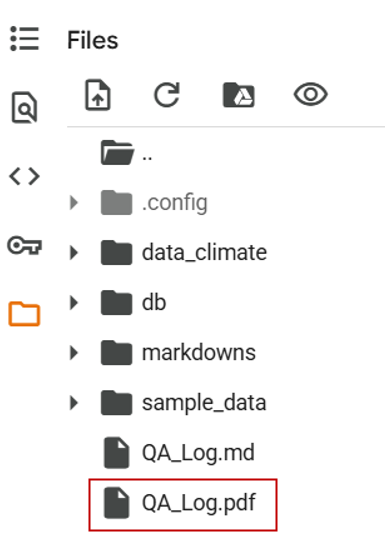

### In this Colab notebook, we built a scientific RAG (Retrieval-Augmented Generation) pipeline that extracts information from PDF/XML-formatted research papers focused on biodiversity, wildlife, phytochemicals, and conservation. We parsed these XMLs into structured Markdown, embedded them using all-mpnet-base-v2, and connected them to a powerful LLM (LLaMA3-70B via Groq). The assistant can now accurately answer questions about scientific names, compounds, study locations, methodologies, and research findings — all grounded in real literature.

###**References:**
- Garg A, Smith-Unna R D and Mu
rray-Rust P, (pygetpapers:
A   Python   library   for   automated   retrieval   of   scientific
literature,Journal  of  Open  Source  Software,7(75)(2022)4451. https://doi.org/10.21105/joss.04451

- [groqcloud](https://groq.com/groqcloud/)
